# ECE381V HW4- Mingyo Seo (EID: ms84662)

We consider the descrete dynamic model with the time step $\Delta t = 0.05$. All the parameters used in the simulation are given as the problem.

In [1]:
import os
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import seaborn as sns

np.set_printoptions(precision=2)

CONTOL_MIN = -0.3
CONTOL_MAX = 0.3

STEP_MAX = 400

GRAVITY = 9.8
INERTIA = 0.0475
RADIUS = 0.25
MASS = 4.0
AERODYNAMIC_COEFF = 0.05

TIME_STEP = 0.05

INIT_STATE = np.zeros(6)
REF_STATE = np.array([1, 1, 0, 0, 0, 0])

In [2]:
def plot_results(results):
    fig, axs = plt.subplots(5)

    for key in [20, 150]:
        axs[0].plot(results[key]['time'], results[key]['state'][:-1,0], label="{} steps".format(key))
        axs[1].plot(results[key]['time'], results[key]['state'][:-1,1], label="{} steps".format(key))
        axs[2].plot(results[key]['time'], results[key]['state'][:-1,2], label="{} steps".format(key))
        axs[3].plot(results[key]['time'], results[key]['control'][:,0], label="{} steps".format(key))
        axs[4].plot(results[key]['time'], results[key]['control'][:,1], label="{} steps".format(key))

    axs[0].set_ylabel("X-Position [m]")
    axs[1].set_ylabel("Y-Position [m]")
    axs[2].set_ylabel("Roll [rad]")
    axs[3].set_ylabel("F_x [N]")
    axs[4].set_ylabel("F_y [N]")
    axs[4].set_xlabel("Time [sec]")

    axs[0].set_ylim(-0.5, 1.5)
    axs[1].set_ylim(-0.5, 1.5)
    axs[2].set_ylim(-0.5, 0.5)
    axs[3].set_ylim(-0.5, 0.5)
    axs[4].set_ylim(-0.5, 0.5)

    axs[4].legend(loc="lower right")

    fig.set_figwidth(8)
    fig.set_figheight(8)

    plt.show()

The dynamics of the vectored thrust aircraft can be formulated as below,
<br>
$
\dot{\xi} = A \xi + B u
$,
<br>
where 
$A(\xi) = 
\begin{bmatrix}
0 & 0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 0 & 1\\
0 & 0 & -g & -{c}\over{m} & 0 & 0\\
0 & 0 & 0 & 0 & -{c}\over{m} & 0\\
0 & 0 & 0 & 0 & 0 & 0
\end{bmatrix}
$,
and 
$
B(\xi) = 
\begin{bmatrix}
0 & 0\\
0 & 0\\
0 & 0\\
{\cos{\theta}}\over{m} & -{\sin{\theta}}\over{m}\\
{\sin{\theta}}\over{m} & {\cos{\theta}}\over{m}\\
{r}\over{J} & 0
\end{bmatrix}.
$
<br>
We define `get_dynamics` function to get matricies $A$ and $B$ for a given state $\xi$. 

In [3]:
def get_dynamics(state):

    roll = state[2]
    
    mat_A = np.zeros((6,6))
    mat_A[:3,3:] = np.eye(3)
    mat_A[3,2] = - GRAVITY
    mat_A[3,3] = - AERODYNAMIC_COEFF/MASS
    mat_A[4,4] = - AERODYNAMIC_COEFF/MASS

    mat_B = np.zeros((6,2))
    mat_B[3:5,0:2] = 1/MASS * np.array([[np.cos(roll), -np.sin(roll)], [np.sin(roll), np.cos(roll)]])
    mat_B[5,0] = RADIUS/INERTIA
    
    return mat_A, mat_B

We also define `run_mpc` function to compute controls with the finite-horizon steps. In the process of MPC, we use a linearised dynamics at a given reference state $\xi_{ref}$.

In [4]:
def run_mpc(cur_state, ref_state, horizon, dt=TIME_STEP):

    assert cur_state.shape == ref_state.shape
    mat_A, mat_B = get_dynamics(ref_state)
    control_dim = mat_B.shape[1]
    state_dim = cur_state.shape[0]
    
    U = cp.Variable((horizon, control_dim))
    X = cp.Variable((horizon+1, state_dim))
    
    const = []
    const.append(U <= CONTOL_MAX)
    const.append(U >= CONTOL_MIN)

    const.append(X[0,:]+ref_state == cur_state)

    for i in range(horizon):
        const.append(X[i+1,:] == X[i,:] + dt * (mat_A @ (X[i,:]+ref_state) + mat_B @ U[i,:]) )

    cost = cp.sum((X[:,:])**2) + cp.sum((U[:,:])**2)
        
    prob = cp.Problem(cp.Minimize(cost), const)
    prob.solve()

    controls = U.value
    states = X.value + ref_state
    
    return controls[0]

Finally, we define `mpc_experiment` function for simulating the dynamics and recording MPC trajectories. When the mode is defined as `mode="linearized"`, we use a linearized dynamics as given in the problem. Otherwise, we use the actual dynamic model given at the current $\xi$. The homework problem does not seem to ask this case `mode="actual"`, but I added this case for to further show the performance of MPC.

In [5]:
def mpc_experiment(init_state, ref_state, horizon=20, mode="linearized"):

    results = {'state':[], 'control':[], 'time':[]}

    cur_state = np.copy(init_state)
    results['state'].append(np.copy(cur_state))

    for idx in range(STEP_MAX):
        if mode == "linearized":
            mat_A, mat_B = get_dynamics(ref_state)
        else:
            mat_A, mat_B = get_dynamics(cur_state)
        control = run_mpc(cur_state, ref_state, horizon)
        cur_state += TIME_STEP * (mat_A @ cur_state + mat_B @ control)

        results['state'].append(np.copy(cur_state))
        results['control'].append(np.copy(control))
        results['time'].append(TIME_STEP * idx)

    results['state'] = np.array(results['state'])
    results['control'] = np.array(results['control'])
    results['time'] = np.array(results['time'])
        
    return results

The simulation results of the linearized dynamics are given as below.

In [6]:
result_linear = {}
result_linear[20] = mpc_experiment(INIT_STATE, REF_STATE, horizon=20, mode="linearized")
result_linear[150] = mpc_experiment(INIT_STATE, REF_STATE, horizon=150, mode="linearized")

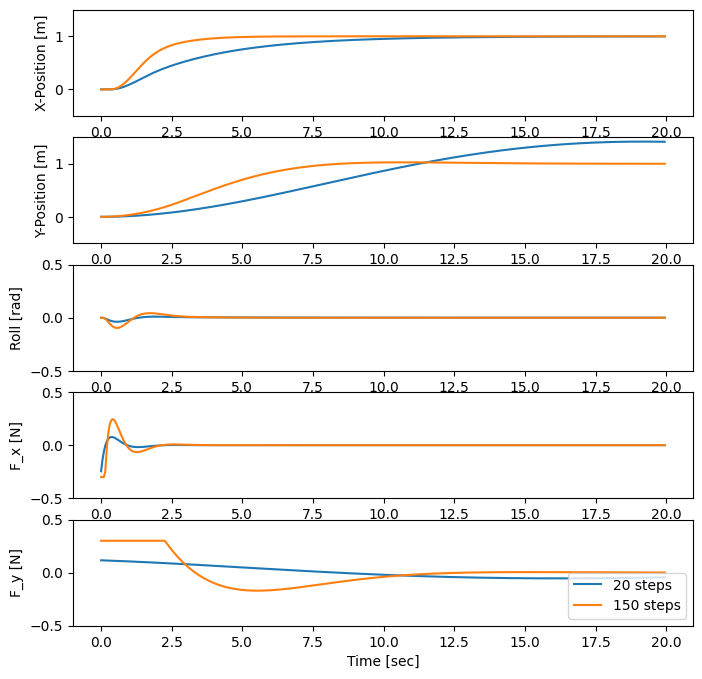

In [7]:
plot_results(result_linear)

The simulation results of the actual dynamics are given as below.

In [8]:
result_actual = {}
result_actual[20] = mpc_experiment(INIT_STATE, REF_STATE, horizon=20, mode="actual")
result_actual[150] = mpc_experiment(INIT_STATE, REF_STATE, horizon=150, mode="actual")

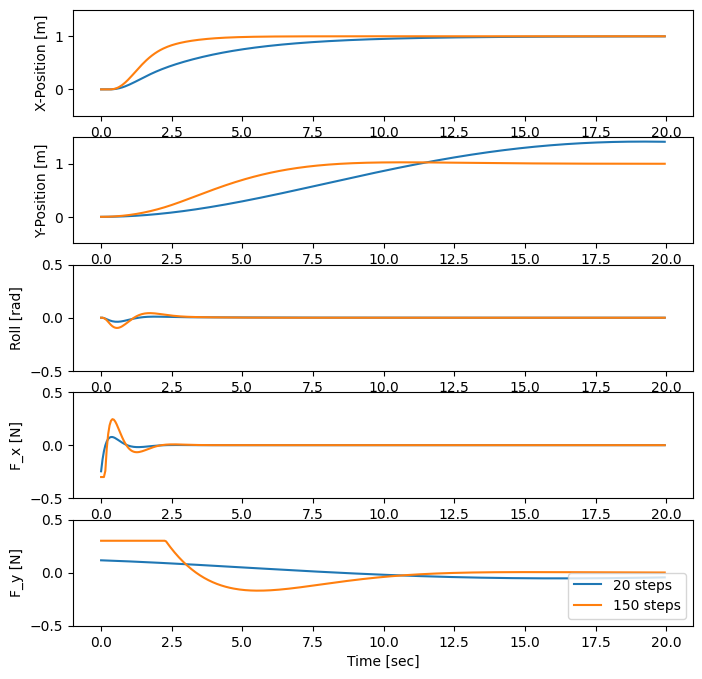

In [9]:
plot_results(result_actual)

From both cases, we can confirm the results that the case of `horizon=150` converges faster and suffer less from overshooting than the case of `horizon=20`.